<a href="https://colab.research.google.com/github/vivekbiju/XAI/blob/main/Xception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opencv-python
!pip install kagglehub
!pip install tensorflow
!pip install shap
!pip install tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 45.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 118.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 45.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 132.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 222.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 38.5 MB/s eta 0:00:00


In [2]:
#imports
import warnings
warnings.filterwarnings('ignore')

import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import kagglehub
import cv2
from tqdm import tqdm

# Keras/TensorFlow specific imports
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.xception import Xception, preprocess_input # Xception specific
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Input, Dropout, GlobalAveragePooling2D
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score
from tensorflow.keras.utils import to_categorical # For ROC curve

In [3]:
# Set consistent random seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# image dimensions
IMG_HEIGHT = 224
IMG_WIDTH = 224

# Helper function for consistent image loading and preprocessing
def load_and_preprocess_single_image(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH)):
    """
    Loads, resizes, converts to RGB, and preprocesses a single image for model input.
    Args:
        img_path (str): Path to the image file.
        target_size (tuple): Desired (height, width) for resizing.
    Returns:
        tuple: (preprocessed_image_array (batch of 1), original_rgb_resized_image, original_full_size_image)
               Returns (None, None, None) if image cannot be loaded.
    """
    img_full_size = cv2.imread(img_path)
    if img_full_size is None:
        return None, None, None

    img_resized = cv2.resize(img_full_size, target_size)
    img_rgb_resized = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
    img_array_preprocessed = preprocess_input(np.expand_dims(img_rgb_resized, axis=0))
    return img_array_preprocessed, img_rgb_resized, cv2.cvtColor(img_full_size, cv2.COLOR_BGR2RGB)

# Professional plotting function for training history
def plot_training(history_obj, title_suffix=""):
    """
    Plots training and validation accuracy and loss in a professional manner.

    Args:
        history_obj: Keras History object containing training logs.
        title_suffix (str): Suffix to add to the plot titles (e.g., "(Initial Training)").
    """
    plt.style.use('seaborn-v0_8-darkgrid')
    plt.figure(figsize=(10, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history_obj.history['accuracy'], label='Train Accuracy', color='#1f77b4', marker='o', markersize=4, linewidth=2)
    plt.plot(history_obj.history['val_accuracy'], label='Validation Accuracy', color='#ff7f0e', marker='x', markersize=4, linewidth=2)
    plt.title(f"Model Accuracy {title_suffix}", fontsize=16, fontweight='bold')
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.ylim([0, 1])

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history_obj.history['loss'], label='Train Loss', color='#2ca02c', marker='o', markersize=4, linewidth=2)
    plt.plot(history_obj.history['val_loss'], label='Validation Loss', color='#d62728', marker='x', markersize=4, linewidth=2)
    plt.title(f"Model Loss {title_suffix}", fontsize=16, fontweight='bold')
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()
    plt.style.use('default')

In [4]:
# Dataset Download
print("Attempting to download dataset...")
try:
    path = kagglehub.dataset_download("bhaveshmittal/melanoma-cancer-dataset")
    print("Path to dataset files:", path)
except Exception as e:
    print(f"Error downloading dataset from Kaggle Hub: {e}")

    exit_script = input("Dataset download failed. Do you want to exit the script? (y/n): ")
    if exit_script.lower() == 'y':
        exit()
    else:
        print("Proceeding without dataset.cause errors later.")
        path = "."

train_path = os.path.join(path, "train")
test_path = os.path.join(path, "test")

Attempting to download dataset...
Path to dataset files: /kaggle/input/melanoma-cancer-dataset


In [5]:
# Check if paths exist after download attempt
if not os.path.exists(train_path) or not os.path.exists(test_path):
    print(f"Error: Training or test path not found. Please ensure the dataset is downloaded correctly to '{path}'.")
    exit()

# Count images function
def count_images(dir_path):
    count = 0
    for category in os.listdir(dir_path):
        count += len(os.listdir(os.path.join(dir_path, category)))
    return count

print(f"Number of train images: {count_images(train_path)}")
print(f"Number of test images: {count_images(test_path)}")

Number of train images: 11879
Number of test images: 2000


Number of images benign: 7289
Number of images malignant: 6590


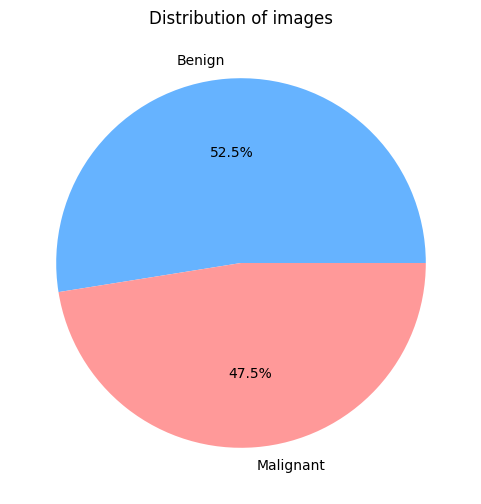

In [6]:
# Count images (for pie chart)
benign_train_count = len(os.listdir(os.path.join(train_path, "Benign")))
malignant_train_count = len(os.listdir(os.path.join(train_path, "Malignant")))
benign_test_count = len(os.listdir(os.path.join(test_path, "Benign")))
malignant_test_count = len(os.listdir(os.path.join(test_path, "Malignant")))

ben = benign_train_count + benign_test_count
mal = malignant_train_count + malignant_test_count

print(f"Number of images benign: {ben}")
print(f"Number of images malignant: {mal}")

plt.figure(figsize=(6,6))
plt.pie([ben, mal], labels=['Benign', 'Malignant'], autopct='%1.1f%%', colors=['#66b3ff','#ff9999'])
plt.title("Distribution of images")
plt.show()


 sample Benign images


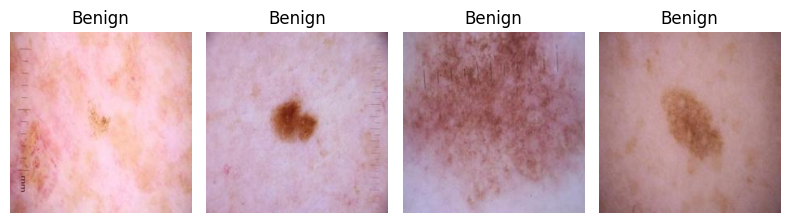


 sample Malignant images


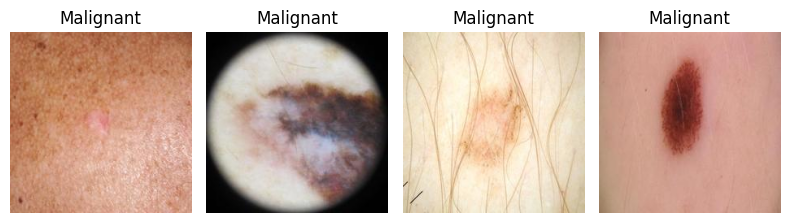

In [7]:
# Sample Images

print("\n sample Benign images")
plt.figure(figsize=(8, 5))
benign_sample_images = [f for f in os.listdir(os.path.join(train_path, 'Benign')) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
for i, img_name in enumerate(benign_sample_images[:4]):
    img_path = os.path.join(train_path, 'Benign', img_name)
    _, img_rgb_display, _ = load_and_preprocess_single_image(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    if img_rgb_display is not None:
        plt.subplot(2, 4, i + 1)
        plt.imshow(img_rgb_display)
        plt.title("Benign")
        plt.axis('off')
plt.tight_layout()
plt.show()

print("\n sample Malignant images")
plt.figure(figsize=(8, 5))
malignant_sample_images = [f for f in os.listdir(os.path.join(train_path, 'Malignant')) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
for i, img_name in enumerate(malignant_sample_images[:4]):
    img_path = os.path.join(train_path, 'Malignant', img_name)
    _, img_rgb_display, _ = load_and_preprocess_single_image(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    if img_rgb_display is not None:
        plt.subplot(2, 4, i + 1)
        plt.imshow(img_rgb_display)
        plt.title("Malignant")
        plt.axis('off')
plt.tight_layout()
plt.show()


In [8]:
#  Data Generators with Xception preprocess

print("\nSetting up data generators...")
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    horizontal_flip=True,
    rotation_range=10,
    brightness_range=[0.8,1.2],
)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

val_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=42
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    seed=42
)


Setting up data generators...
Found 9504 images belonging to 2 classes.
Found 2375 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [9]:
# Model Xception

print("\nBuilding Xception-based model...")
inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model = Xception(weights='imagenet', include_top=False, input_tensor=inputs)
base_model.trainable = False

x = base_model.output
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(1e-3))(x)
x = Dropout(0.3)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=Adam(learning_rate=5e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


# Callbacks

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True,
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

callbacks = [early_stopping, reduce_lr]


Building Xception-based model...
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 111, 111,  │        864 │ input_layer[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 111, 111,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 111, 111,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 109, 109,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 109, 109,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 109, 109,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 109, 109,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 109, 109,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 109, 109,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 109, 109,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 109, 109,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 55, 55,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 55, 55,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 55, 55,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 55, 55,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 55, 55,    │          0 │ add[0][0]       

 Total params: 21,919,786 (83.62 MB)

 Trainable params: 1,054,210 (4.02 MB)

 Non-trainable params: 20,865,576 (79.60 MB)

In [10]:
# Train Model

print("\nStarting initial model training (feature extraction) with Xception...")
start_time = time.time()

history = model.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator,
    callbacks=callbacks,
)

end_time = time.time()
hours, rem = divmod(end_time - start_time, 3600)
minutes, seconds = divmod(rem, 60)
print(f"\nTotal initial training time: {int(hours)}h {int(minutes)}m {int(seconds)}s")


# Fine-tuning

print("\nStarting fine-tuning of the Xception model...")
base_model.trainable = True

for layer in base_model.layers[:-50]:
    layer.trainable = False

# Recompile with a very low learning rate for fine-tuning
optimizer_finetune = Adam(learning_rate=1e-5)
model.compile(optimizer=optimizer_finetune, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Starting initial model training (feature extraction) with Xception...
Epoch 1/15
297/297 ━━━━━━━━━━━━━━━━━━━━ 165s 549ms/step - accuracy: 0.8300 - loss: 1.1423 - val_accuracy: 0.7629 - val_loss: 1.0626 - learning_rate: 5.0000e-04
Epoch 2/15
297/297 ━━━━━━━━━━━━━━━━━━━━ 131s 441ms/step - accuracy: 0.8904 - loss: 0.7426 - val_accuracy: 0.7945 - val_loss: 0.8442 - learning_rate: 5.0000e-04
Epoch 3/15
297/297 ━━━━━━━━━━━━━━━━━━━━ 130s 439ms/step - accuracy: 0.9064 - loss: 0.5850 - val_accuracy: 0.7912 - val_loss: 0.7520 - learning_rate: 5.0000e-04
Epoch 4/15
297/297 ━━━━━━━━━━━━━━━━━━━━ 130s 439ms/step - accuracy: 0.8930 - loss: 0.5087 - val_accuracy: 0.8189 - val_loss: 0.6602 - learning_rate: 5.0000e-04
Epoch 5/15
297/297 ━━━━━━━━━━━━━━━━━━━━ 130s 439ms/step - accuracy: 0.9023 - loss: 0.4302 - val_accuracy: 0.8173 - val_loss: 0.5903 - learning_rate: 5.0000e-04
Epoch 6/15
297/297 ━━━━━━━━━━━━━━━━━━━━ 130s 436ms/step - accuracy: 0.9101 - loss: 0.3819 - val_accuracy: 0.7983 - val_loss: 0.60

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 111, 111,  │        864 │ input_layer[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 111, 111,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 111, 111,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 109, 109,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 109, 109,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 109, 109,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 109, 109,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 109, 109,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 109, 109,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 109, 109,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 109, 109,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 55, 55,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 55, 55,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 55, 55,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 55, 55,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 55, 55,    │          0 │ add[0][0]       

 Total params: 21,919,786 (83.62 MB)

 Trainable params: 13,222,514 (50.44 MB)

 Non-trainable params: 8,697,272 (33.18 MB)

In [11]:
history_finetune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=callbacks
)

# Save the trained model
model_save_path = "melanoma_xception_model.h5"
try:
    model.save(model_save_path)
    print(f"\nModel saved successfully at: {model_save_path}")
except Exception as e:
    print(f"Error saving model: {e}")

Epoch 1/15
297/297 ━━━━━━━━━━━━━━━━━━━━ 179s 583ms/step - accuracy: 0.8658 - loss: 0.3874 - val_accuracy: 0.7992 - val_loss: 0.5570 - learning_rate: 1.0000e-05
Epoch 2/15
297/297 ━━━━━━━━━━━━━━━━━━━━ 172s 578ms/step - accuracy: 0.8977 - loss: 0.3113 - val_accuracy: 0.8143 - val_loss: 0.5017 - learning_rate: 1.0000e-05
Epoch 3/15
297/297 ━━━━━━━━━━━━━━━━━━━━ 172s 578ms/step - accuracy: 0.9195 - loss: 0.2807 - val_accuracy: 0.8118 - val_loss: 0.5191 - learning_rate: 1.0000e-05
Epoch 4/15
297/297 ━━━━━━━━━━━━━━━━━━━━ 172s 577ms/step - accuracy: 0.9237 - loss: 0.2644 - val_accuracy: 0.8240 - val_loss: 0.5161 - learning_rate: 1.0000e-05
Epoch 5/15
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step - accuracy: 0.9362 - loss: 0.2451
Epoch 5: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
297/297 ━━━━━━━━━━━━━━━━━━━━ 172s 578ms/step - accuracy: 0.9362 - loss: 0.2451 - val_accuracy: 0.8211 - val_loss: 0.5216 - learning_rate: 1.0000e-05
Epoch 6/15
297/297 ━━━━━━━━━━━━━━━━━━━━ 172s 5


Model saved successfully at: melanoma_xception_model.h5


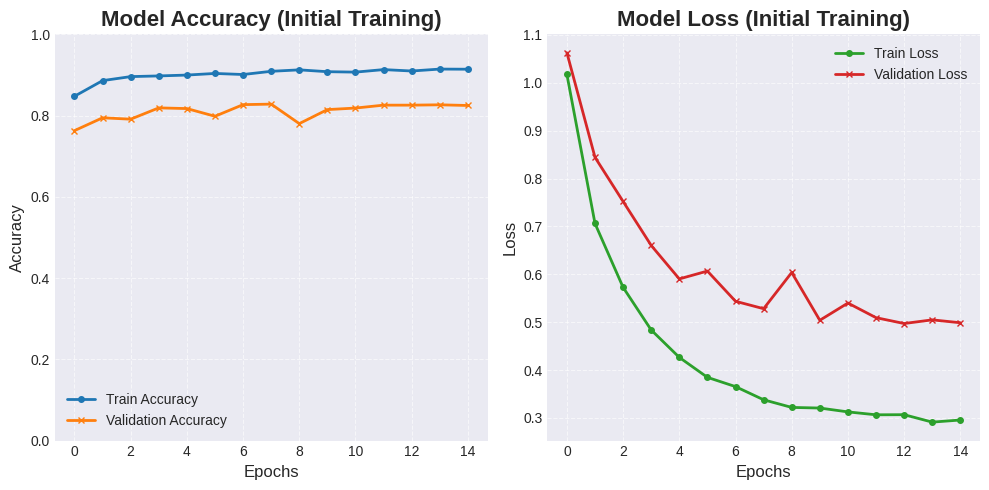

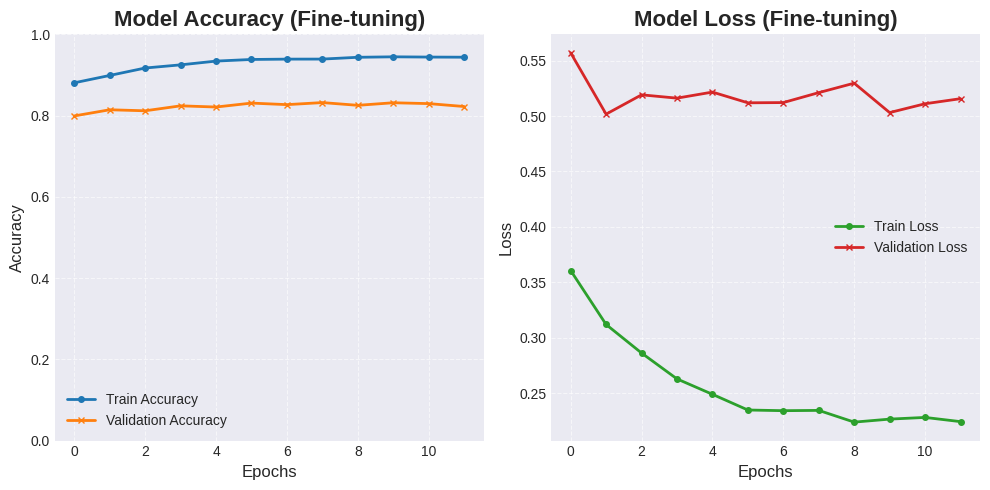

In [12]:
# Plot Training & Validation Accuracy and Loss

plot_training(history, "(Initial Training)")
plot_training(history_finetune, "(Fine-tuning)")


Evaluating model on the test set...
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 256ms/step - accuracy: 0.9349 - loss: 0.2445
Test Accuracy: 88.50%
Test Loss: 0.3527
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 265ms/step


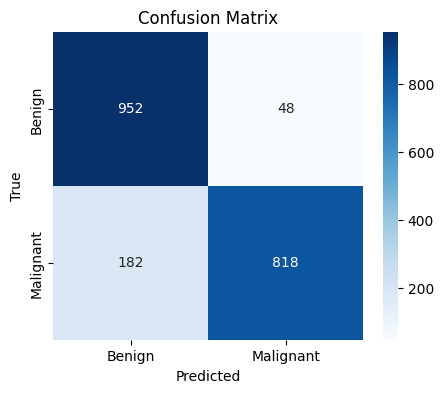

Classification Report:

              precision    recall  f1-score   support

      Benign       0.84      0.95      0.89      1000
   Malignant       0.94      0.82      0.88      1000

    accuracy                           0.89      2000
   macro avg       0.89      0.89      0.88      2000
weighted avg       0.89      0.89      0.88      2000



In [13]:
# Evaluate on Test Set

print("\nEvaluating model on the test set...")
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

test_generator.reset()
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())


# Confusion Matrix & Classification Report

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))



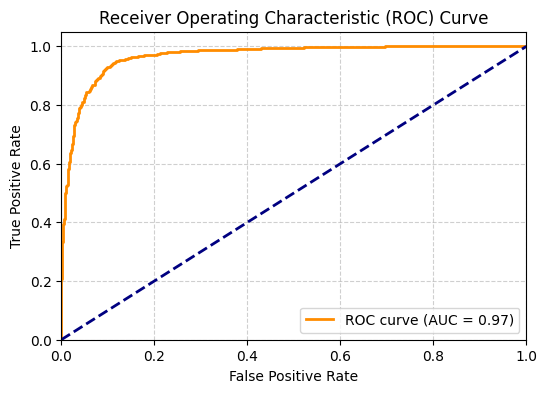

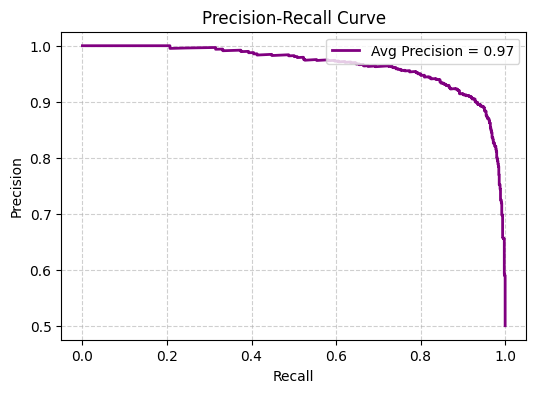

In [14]:
# ROC Curve

if y_pred_probs.shape[1] == 2:
    y_true_categorical = to_categorical(y_true, num_classes=2)
    fpr, tpr, thresholds = roc_curve(y_true_categorical[:,1], y_pred_probs[:,1])
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()


# Precision-Recall Curve

precision, recall, thresholds_pr = precision_recall_curve(y_true_categorical[:,1], y_pred_probs[:,1])
average_precision = average_precision_score(y_true_categorical[:,1], y_pred_probs[:,1])

plt.figure(figsize=(6,4))
plt.plot(recall, precision, color='purple', lw=2, label=f'Avg Precision = {average_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()



Visualizing sample predictions from the test set...


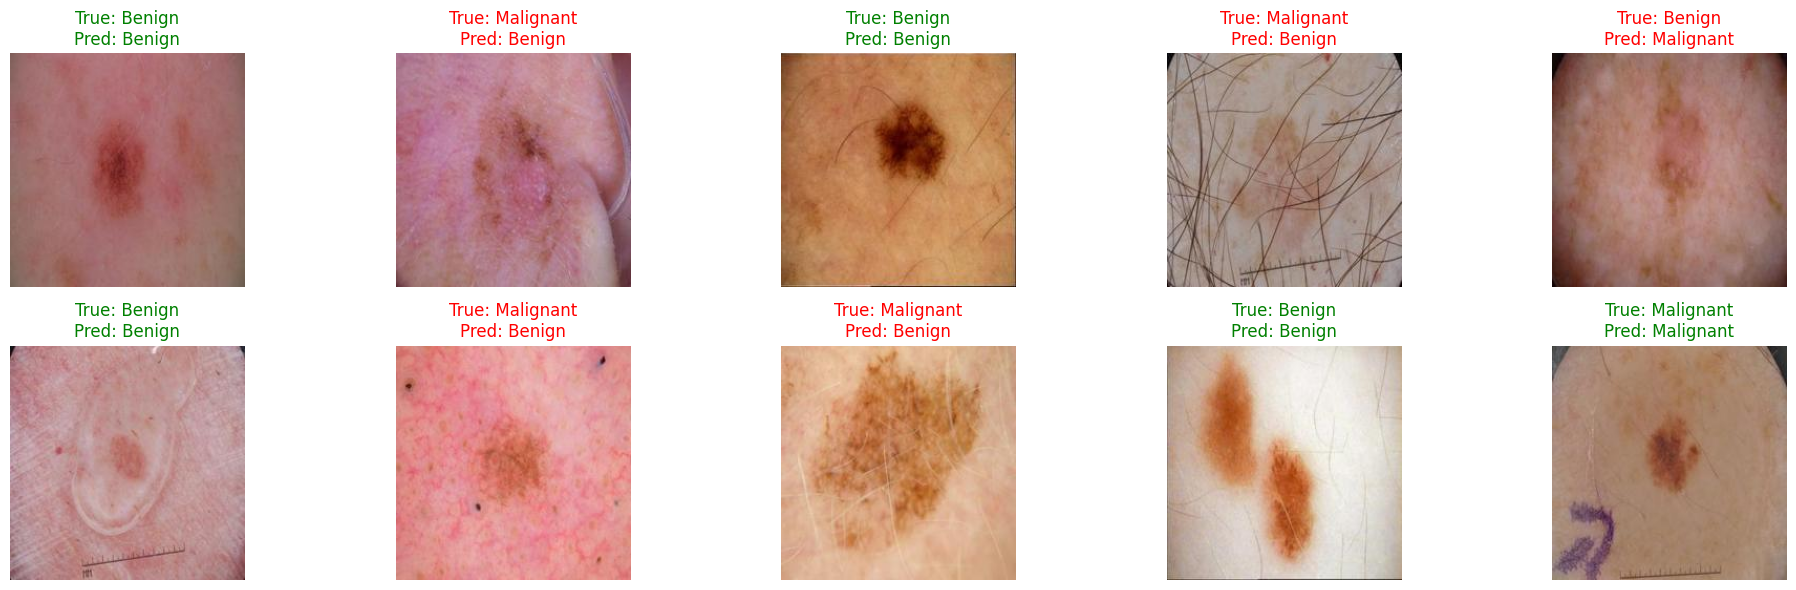

In [15]:

# Prediction and Visualisation (Random Samples)

def visualise_predictions(model, generator, class_names, num_images=10):
    """
    Visualises predictions for a few images from a generator, prioritizing misclassified.
    Args:
        model: Trained Keras model.
        generator: Keras ImageDataGenerator.
        class_names (list): List of class names.
        num_images (int): Number of images to visualise.
    """
    generator.reset()
    true_labels_arr = generator.classes
    pred_labels_arr = np.argmax(model.predict(generator, verbose=0), axis=1)

    correct_indices = np.where(true_labels_arr == pred_labels_arr)[0]
    incorrect_indices = np.where(true_labels_arr != pred_labels_arr)[0]

    selected_indices = []
    num_incorrect_to_pick = min(num_images // 2, len(incorrect_indices))
    num_correct_to_pick = min(num_images - num_incorrect_to_pick, len(correct_indices))

    selected_indices.extend(random.sample(list(incorrect_indices), num_incorrect_to_pick))
    selected_indices.extend(random.sample(list(correct_indices), num_correct_to_pick))
    random.shuffle(selected_indices)

    if not selected_indices:
        print("No images to visualize (dataset might be empty or no predictions made).")
        return

    plt.figure(figsize=(20, 3 * (num_images // 5 + (1 if num_images % 5 != 0 else 0))))
    for i, idx in enumerate(selected_indices[:num_images]):
        img_path = generator.filepaths[idx]
        _, img_rgb_display, _ = load_and_preprocess_single_image(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))

        if img_rgb_display is None:
            print(f"Could not load image {img_path}. Skipping.")
            continue
        img_display_norm = img_rgb_display.astype(np.float32) / 255.0

        true_label = class_names[true_labels_arr[idx]]
        predicted_label = class_names[pred_labels_arr[idx]]

        plt.subplot(num_images // 5 + (1 if num_images % 5 != 0 else 0), 5, i + 1)
        plt.imshow(img_display_norm)
        color = "green" if true_label == predicted_label else "red"
        plt.title(f"True: {true_label}\nPred: {predicted_label}", color=color)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Get class names from test generator
class_names = list(test_generator.class_indices.keys())

# Visualise predictions
print("\nVisualizing sample predictions from the test set...")
visualise_predictions(model, test_generator, class_names, num_images=10)


--- Starting Grad-CAM Explanations ---

Attempting to visualize 10 images with Grad-CAM (prioritizing misclassified).


Generating Grad-CAMs:   0%|          | 0/10 [00:00<?, ?it/s]

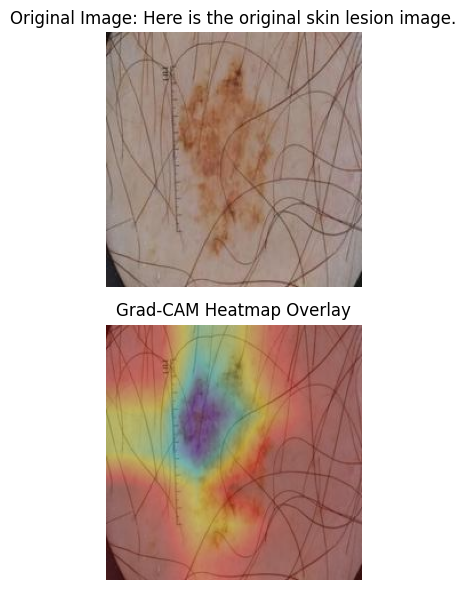

Generating Grad-CAMs:  10%|█         | 1/10 [00:00<00:05,  1.68it/s]

Heatmap Overlaid on Image: "The model focused on these areas (in red/yellow) to make its prediction."
Explanation: "The model predicts this lesion as Malignant with a confidence of 66.34%. The red regions represent areas that the model believes to be most indicative of malignant tissue. These areas may correspond to the irregular texture, shape, or color associated with cancerous tissue."


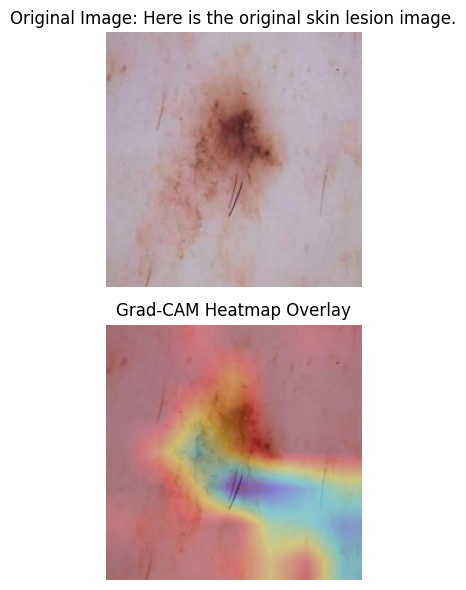

Generating Grad-CAMs:  20%|██        | 2/10 [00:01<00:04,  1.69it/s]

Heatmap Overlaid on Image: "The model focused on these areas (in red/yellow) to make its prediction."
Explanation: "The model predicts this lesion as Benign with a confidence of 68.52%. The red regions represent areas that the model believes to be most indicative of benign tissue. These areas may correspond to the irregular texture, shape, or color associated with cancerous tissue."


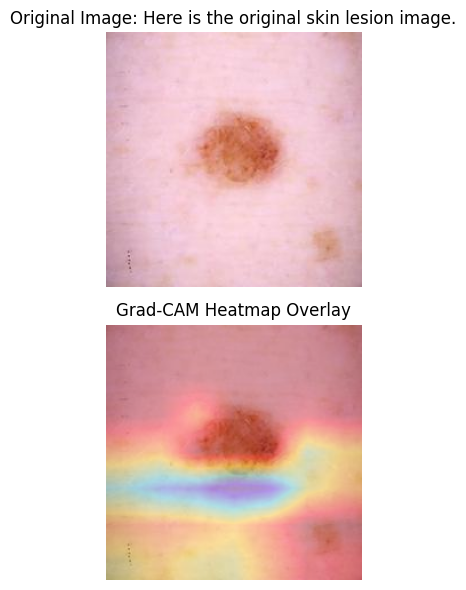

Generating Grad-CAMs:  30%|███       | 3/10 [00:01<00:04,  1.69it/s]

Heatmap Overlaid on Image: "The model focused on these areas (in red/yellow) to make its prediction."
Explanation: "The model predicts this lesion as Benign with a confidence of 99.32%. The red regions represent areas that the model believes to be most indicative of benign tissue. These areas may correspond to the irregular texture, shape, or color associated with cancerous tissue."


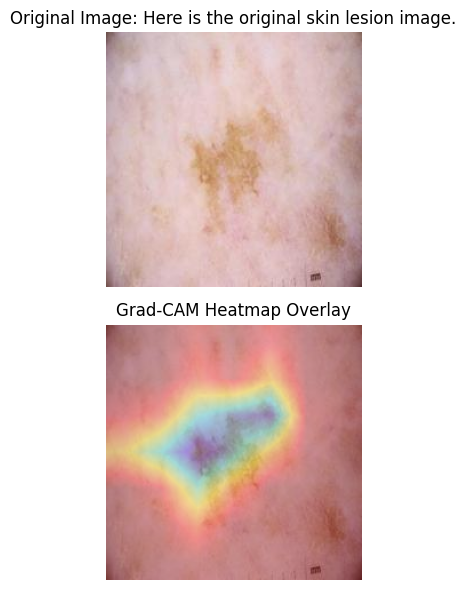

Generating Grad-CAMs:  40%|████      | 4/10 [00:02<00:03,  1.68it/s]

Heatmap Overlaid on Image: "The model focused on these areas (in red/yellow) to make its prediction."
Explanation: "The model predicts this lesion as Malignant with a confidence of 50.90%. The red regions represent areas that the model believes to be most indicative of malignant tissue. These areas may correspond to the irregular texture, shape, or color associated with cancerous tissue."


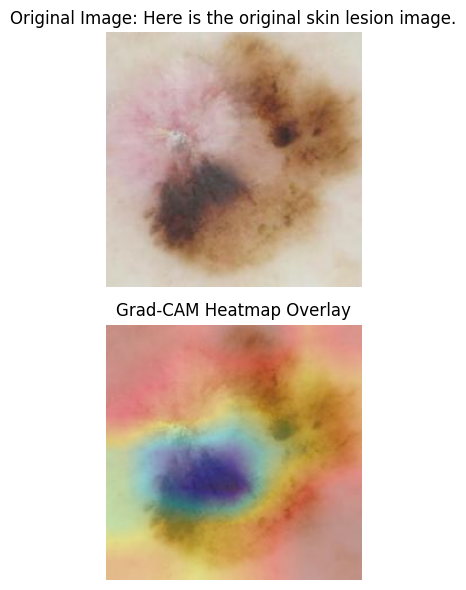

Generating Grad-CAMs:  50%|█████     | 5/10 [00:02<00:02,  1.68it/s]

Heatmap Overlaid on Image: "The model focused on these areas (in red/yellow) to make its prediction."
Explanation: "The model predicts this lesion as Malignant with a confidence of 99.24%. The red regions represent areas that the model believes to be most indicative of malignant tissue. These areas may correspond to the irregular texture, shape, or color associated with cancerous tissue."


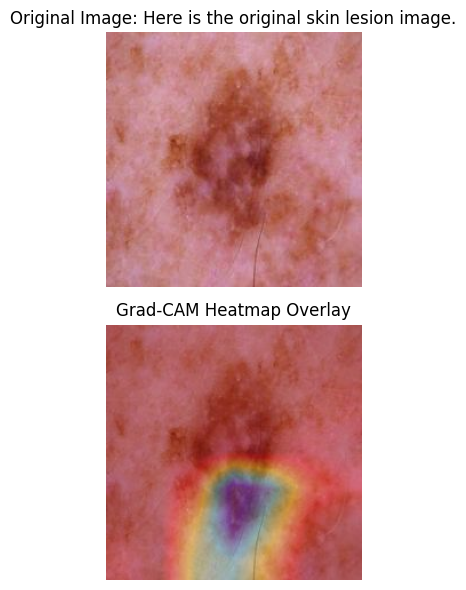

Generating Grad-CAMs:  60%|██████    | 6/10 [00:03<00:02,  1.67it/s]

Heatmap Overlaid on Image: "The model focused on these areas (in red/yellow) to make its prediction."
Explanation: "The model predicts this lesion as Benign with a confidence of 66.87%. The red regions represent areas that the model believes to be most indicative of benign tissue. These areas may correspond to the irregular texture, shape, or color associated with cancerous tissue."


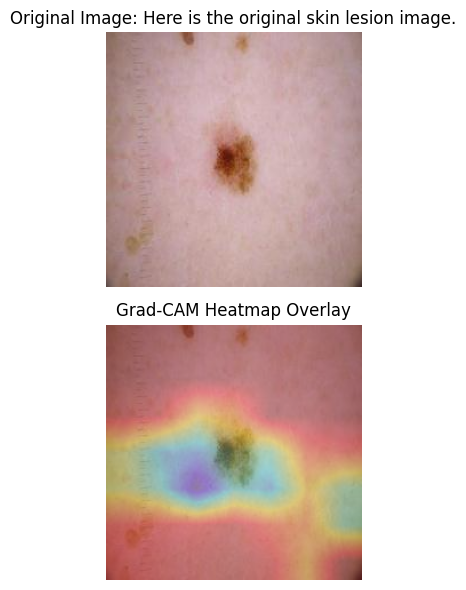

Generating Grad-CAMs:  70%|███████   | 7/10 [00:04<00:02,  1.43it/s]

Heatmap Overlaid on Image: "The model focused on these areas (in red/yellow) to make its prediction."
Explanation: "The model predicts this lesion as Benign with a confidence of 99.47%. The red regions represent areas that the model believes to be most indicative of benign tissue. These areas may correspond to the irregular texture, shape, or color associated with cancerous tissue."


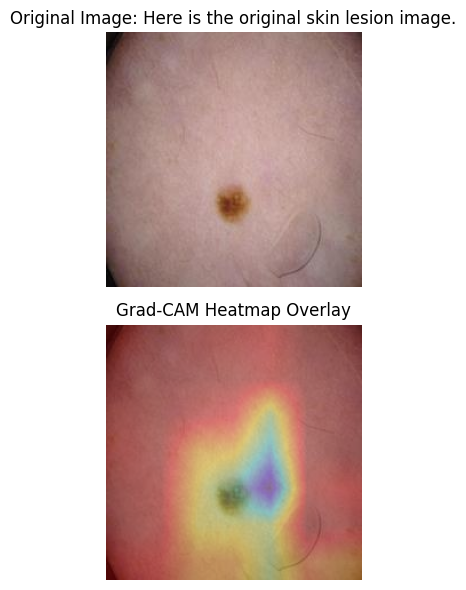

Generating Grad-CAMs:  80%|████████  | 8/10 [00:05<00:01,  1.50it/s]

Heatmap Overlaid on Image: "The model focused on these areas (in red/yellow) to make its prediction."
Explanation: "The model predicts this lesion as Benign with a confidence of 90.66%. The red regions represent areas that the model believes to be most indicative of benign tissue. These areas may correspond to the irregular texture, shape, or color associated with cancerous tissue."


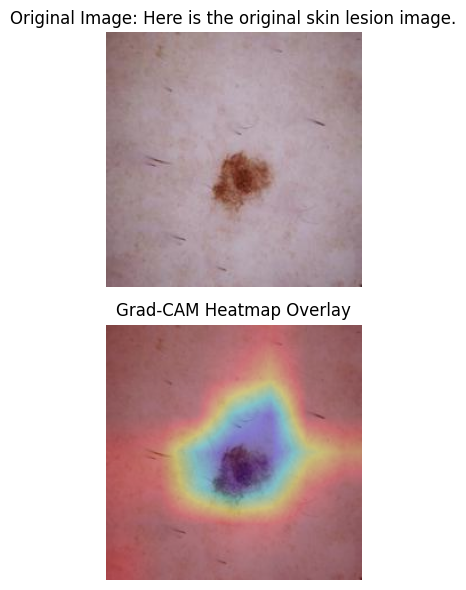

Generating Grad-CAMs:  90%|█████████ | 9/10 [00:05<00:00,  1.55it/s]

Heatmap Overlaid on Image: "The model focused on these areas (in red/yellow) to make its prediction."
Explanation: "The model predicts this lesion as Benign with a confidence of 84.14%. The red regions represent areas that the model believes to be most indicative of benign tissue. These areas may correspond to the irregular texture, shape, or color associated with cancerous tissue."


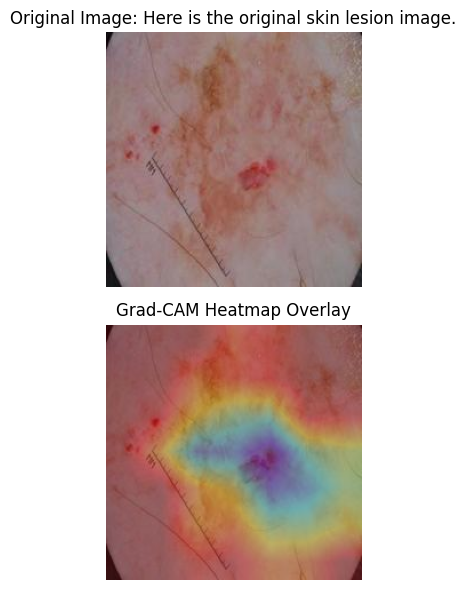

Generating Grad-CAMs: 100%|██████████| 10/10 [00:06<00:00,  1.59it/s]

Heatmap Overlaid on Image: "The model focused on these areas (in red/yellow) to make its prediction."
Explanation: "The model predicts this lesion as Malignant with a confidence of 80.27%. The red regions represent areas that the model believes to be most indicative of malignant tissue. These areas may correspond to the irregular texture, shape, or color associated with cancerous tissue."

 Grad-CAM explanations generated and displayed successfully.


In [18]:
# Grad-CAM

print("\n" + "="*50)
print("--- Starting Grad-CAM Explanations ---")
print("="*50 + "\n")

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """
    Generates Grad-CAM heatmap for a given image and model.
    Args:
        img_array: Preprocessed image array (batch of 1: (1, H, W, C)).
        model: Trained Keras model.
        last_conv_layer_name: Name of the last convolutional layer in the base model.
        pred_index: Optional. If specified, computes heatmap for this class.
                    Otherwise, computes for the top predicted class.
    Returns:
        Numpy array representing the heatmap or None if gradient is None.
    """
    last_conv_layer_output = model.get_layer(last_conv_layer_name).output
    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[last_conv_layer_output, model.output]
    )

    img_array = tf.cast(img_array, tf.float32)

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)

        if pred_index is None:
            pred_index = tf.argmax(predictions[0])

        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)

    if grads is None:
        print("Gradient is None. Returning None for heatmap.")
        return None

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + tf.keras.backend.epsilon())

    heatmap = tf.cast(heatmap, tf.float32)
    return heatmap.numpy()

# Grad-CAM Visualization Loop
idx_to_class = {v: k for k, v in test_generator.class_indices.items()}
test_generator.reset()
test_pred_probs = model.predict(test_generator, verbose=0)
test_pred_labels = np.argmax(test_pred_probs, axis=1)

test_true_labels = test_generator.classes
# Separate indices for correct and incorrect predictions
correctly_classified_indices = np.where(test_true_labels == test_pred_labels)[0]
misclassified_indices = np.where(test_true_labels != test_pred_labels)[0]

num_samples_to_visualize_gradcam = 10
sample_indices_gradcam = []
num_misclassified_to_pick = min(num_samples_to_visualize_gradcam // 2, len(misclassified_indices))
num_correct_to_pick = min(num_samples_to_visualize_gradcam - num_misclassified_to_pick, len(correctly_classified_indices))

sample_indices_gradcam.extend(random.sample(list(misclassified_indices), num_misclassified_to_pick))
sample_indices_gradcam.extend(random.sample(list(correctly_classified_indices), num_correct_to_pick))
random.shuffle(sample_indices_gradcam)

print(f"Attempting to visualize {len(sample_indices_gradcam)} images with Grad-CAM (prioritizing misclassified).")
last_conv_layer_name = 'block14_sepconv2_act'

for i in tqdm(sample_indices_gradcam, desc="Generating Grad-CAMs"):
    img_path = test_generator.filepaths[i]
    img_array_preprocessed, img_rgb_resized, img_rgb_original_full_size = load_and_preprocess_single_image(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))

    if img_array_preprocessed is None:
        print(f"Could not read image at {img_path}. Skipping for Grad-CAM.")
        continue

    original_height, original_width = img_rgb_original_full_size.shape[:2]

    # Get model's predicted class and confidence for this image
    predicted_probs = model.predict(img_array_preprocessed, verbose=0)
    predicted_class_idx = np.argmax(predicted_probs[0])
    predicted_class_label = idx_to_class[predicted_class_idx]
    confidence = predicted_probs[0][predicted_class_idx] * 100

    # Generate heatmap for the predicted class
    heatmap = make_gradcam_heatmap(img_array_preprocessed, model, last_conv_layer_name, pred_index=predicted_class_idx)

    if heatmap is not None:
        heatmap_resized = cv2.resize(heatmap, (original_width, original_height))
        heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
        superimposed_img = cv2.addWeighted(img_rgb_original_full_size, 0.7, heatmap_colored, 0.3, 0)

        plt.figure(figsize=(12, 6))
        plt.subplot(2, 1, 1)
        plt.imshow(img_rgb_original_full_size)
        plt.title("Original Image: Here is the original skin lesion image.")
        plt.axis('off')

        plt.subplot(2, 1, 2)
        plt.imshow(superimposed_img)
        plt.title("Grad-CAM Heatmap Overlay")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

        print(f'Heatmap Overlaid on Image: "The model focused on these areas (in red/yellow) to make its prediction."')
        print(f'Explanation: "The model predicts this lesion as {predicted_class_label} with a confidence of {confidence:.2f}%. '
              f'The red regions represent areas that the model believes to be most indicative of {predicted_class_label.lower()} tissue. '
              f'These areas may correspond to the irregular texture, shape, or color associated with cancerous tissue."')
        plt.pause(0.1)
    else:
        print(f"Could not generate Grad-CAM for image at index {i}.")

print("\n Grad-CAM explanations generated and displayed successfully.")